## Model construction and training
This notebook includes importing and unpacking data that have been preprocessed for model training and training CNN model vX. Details about other CNN model architectures tested so far are reported in the README summary. This training is only on the original spectrograms, in the format resulting from preprocessing. Incorporating the _augmented_ spectrograms into the training data occurs in the next notebook. These processes were kept separate in order to compare the results between models trained with and without augmented data.

Spectrograms used for training here have already been **standardized** (standard-scaler within each array, not across whole dataset), **reshaped**, and train-test-splat into 9 subsets of equal pos:neg ratios.  

This format is due to memory limitations: training the model on all data at once was not possible on my machine, nor on extra capacity from AWS.  The 9 train-test chunks are fed to the model sequentially. Trial and error proved that implementing EarlyStop helped overall model performance; in general, EarlyStop makes sense: it's more efficient, and allows a target metric to be tracked. However, with this subset format, that means that the model may train on each subset for a unique number of epochs. Thus this subset format is **not directly parallel** to training on all data at once. For most versions of the model fit so far, subsets have been presented in order 0-8. In the iteration below, I reverse this order; the overall performance of model vX will be the average across multiple fittings.


The basic architecture for this model is derived from deep learning networks used for marine mammal acoustics found in literature review. These sources were operating with data of different volumes, from different environments, and often to different ends (ie multiclass classification, or dealing with species unique calls & frequency ranges). Thus, no network from prior literature was ready 'out of the box' for this project, but they were a better starting point than completely winging it. NNs from these sources had to be made much shallower to fit within my memory limits.

---
Sources guiding CNN structure:  
* [Padovese et al. 2021.](https://asa.scitation.org/doi/full/10.1121/10.0004258) Data augmentation for the classification of North Atlantic right whales upcalls. _Journal of the Acoustical Society of America_ 149:4.
* [Thomas et al. 2019.](https://ecmlpkdd2019.org/downloads/paper/314.pdf) Marine Mammal Species Classification using CNN and a Novel Acoustic Representation. 
* [Shiu et al. 2020.](https://www.nature.com/articles/s41598-020-57549-y) Deep neural networks for automated detection of marine mammal species. _Nature: Scientific Reports_ 10:607.
* I did not brush up on correct citation format. Please send all complaints to https://github.com/charles-rice

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import gc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
import tensorflow as tf


import random
random.seed(42)

### Model architecture
Basic LeNet construction, preceded by a Conv2D layer with a larger filter and stride to reduce dimensions quickly.

In [2]:
# 3 x convolutional layers with max pooling
cnn = Sequential()
cnn.add(Conv2D(filters = 8, 
               kernel_size=(11,11),
               strides = (4,4), #kernel_size and stride from AlexNet
               activation='relu', 
               input_shape=(610, 368, 1),
               padding = 'valid')) # = no padding
cnn.add(MaxPooling2D(pool_size = (3,3), strides=(2,2)))
cnn.add(BatchNormalization())

cnn.add(Conv2D(filters= 16, 
              kernel_size=(5,5), #LeNet uses 2xconv2d with 5x5 kernel, 2x2 pooling
              activation='relu')) #default strides =1
cnn.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
cnn.add(BatchNormalization())
        
cnn.add(Conv2D(filters = 16,
               kernel_size = (5,5),
               activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))  #output dim = 15 x 8 x 16 = 1920
cnn.add(BatchNormalization())

cnn.add(Flatten())

#input nodes = # features
cnn.add(Dense(1920, activation='relu')) #, kernel_regularizer=l2(.01))) not used in vX
#cnn.add(Dropout(.2)) #not used in vX
cnn.add(Dense(256, activation = 'relu')) #, kernel_regularizer=l2(.01)))
#cnn.add(Dropout(.2))
cnn.add(Dense(1, activation='sigmoid'))

In [3]:
#lower learning rate
slow_Adam = tf.keras.optimizers.Adam(learning_rate=.0001)

In [4]:
# compile model
cnn.compile(loss = 'binary_crossentropy', optimizer=slow_Adam, 
            metrics=['acc', 'Recall', 'Precision'])

In [5]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 90, 8)        976       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 44, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 44, 8)         32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 70, 40, 16)        3216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 20, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 20, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 16, 16)        6

In [6]:
#add earlystop
early_stop = EarlyStopping(monitor='val_recall', patience = 5)

### Preview of a train-test subset

In [7]:
#import data, assign pos/neg
in_path = '../scratch_data/tts_chunked/'
files = os.listdir(in_path)
files #chunks 0-8

['ch5_test.pkl',
 'ch4_test.pkl',
 'ch7_train.pkl',
 'ch1_train.pkl',
 'ch6_train.pkl',
 'ch8_test.pkl',
 'ch2_test.pkl',
 'ch3_test.pkl',
 'ch0_train.pkl',
 'ch8_train.pkl',
 'ch5_train.pkl',
 'ch6_test.pkl',
 'ch7_test.pkl',
 'ch3_train.pkl',
 'ch1_test.pkl',
 'ch0_test.pkl',
 'ch4_train.pkl',
 'ch2_train.pkl']

In [8]:
with open (in_path+'ch0_train.pkl', mode = 'rb') as f:
    ch0_train = pickle.load(f)
with open (in_path+'ch0_test.pkl', mode = 'rb') as j:
    ch0_test = pickle.load(j)

In [9]:
X_train0, y_train0 = list(zip(*ch0_train))
X_train0 = np.array(X_train0)
y_train0 = np.array(y_train0)
print('X_train type and shape:', type(X_train0), X_train0.shape)
print('y_train type and shape:', type(y_train0), y_train0.shape)

X_train type and shape: <class 'numpy.ndarray'> (1875, 610, 368, 1)
y_train type and shape: <class 'numpy.ndarray'> (1875,)


In [10]:
X_test0, y_test0 = list(zip(*ch0_test))
X_test0 = np.array(X_test0)
y_test0 = np.array(y_test0)
print('X_test type and shape:', type(X_test0), X_test0.shape)
print('y_test type and shape:', type(y_test0), y_test0.shape)

X_test type and shape: <class 'numpy.ndarray'> (625, 610, 368, 1)
y_test type and shape: <class 'numpy.ndarray'> (625,)


In [11]:
#confirm consistent y-stratification
print(pd.Series(y_train0).value_counts(normalize=True),'\n')
print(pd.Series(y_test0).value_counts(normalize=True))

0    0.749867
1    0.250133
dtype: float64 

0    0.7504
1    0.2496
dtype: float64


### Fit model
Verbose=1 here in order to monitor progress, apologies for the long output. Small batches necessary for memory.

In [13]:
#function to import, unzip, recast

def pkl_to_CNN(train_file, test_file):
    with open (in_path+train_file, mode = 'rb') as f:
        temp_train = pickle.load(f)
    with open (in_path+test_file, mode = 'rb') as j:
        temp_test = pickle.load(j)
        
    X_train, y_train = list(zip(*temp_train))
    X_test, y_test = list(zip(*temp_test))

    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [14]:
histlist = [] #save history for each subset fit
for i in range(0,9):
    #subbing (8-i) for i this round to feed training subsets in reverse to norm
    X_train, X_test, y_train, y_test = pkl_to_CNN(f'ch{8-i}_train.pkl', f'ch{8-i}_test.pkl')

    history = cnn.fit(X_train, y_train,
                      batch_size=64,
                      validation_data = (X_test, y_test),
                      epochs = 300, #overkill because earlystop
                      callbacks = early_stop, verbose=1)
    histlist.append(history.history)
    
    if i<8: #probably gratuitous
        del X_train, X_test, y_train, y_test
        gc.collect()
    
    print(f'\n\n        chunk {i+1} of 9 fit\n\n')

Epoch 1/300
28/28 [==============================] - 18s 600ms/step - loss: 0.5940 - acc: 0.7375 - recall: 0.1945 - precision: 0.3873 - val_loss: 0.6723 - val_acc: 0.5739 - val_recall: 0.6190 - val_precision: 0.3182
Epoch 2/300
28/28 [==============================] - 16s 563ms/step - loss: 0.3340 - acc: 0.8632 - recall: 0.7365 - precision: 0.7065 - val_loss: 0.5907 - val_acc: 0.7725 - val_recall: 0.1565 - val_precision: 0.6970
Epoch 3/300
28/28 [==============================] - 17s 610ms/step - loss: 0.3511 - acc: 0.8594 - recall: 0.7189 - precision: 0.7285 - val_loss: 0.5543 - val_acc: 0.7742 - val_recall: 0.0952 - val_precision: 1.0000
Epoch 4/300
28/28 [==============================] - 19s 656ms/step - loss: 0.3369 - acc: 0.8722 - recall: 0.7315 - precision: 0.7310 - val_loss: 0.5329 - val_acc: 0.7742 - val_recall: 0.0952 - val_precision: 1.0000
Epoch 5/300
28/28 [==============================] - 17s 589ms/step - loss: 0.3374 - acc: 0.8733 - recall: 0.7551 - precision: 0.7328 - 

In [15]:
#first things first save results before kernel dies!
tf.keras.models.save_model(cnn, '../data/models/vX_rev_nomasks')

/Users/helenmeigs/miniforge3/envs/tensorflow_env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/Users/helenmeigs/miniforge3/envs/tensorflow_env/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1397: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: ../data/models/vX_rev_nomasks/assets


In [16]:
with open ('../data/models/histories/vX_rev_hist.pkl', mode = 'wb') as f:
    pickle.dump(histlist, f)

### Investigate
Final evaluation of all model versions is on holdout test set in later notebook. For now, we've retained the last train-test subset in memory to at least look at _A_ score.

In [17]:
cnn_score = cnn.evaluate(X_test, y_test, verbose=1)
cnn_labels = cnn.metrics_names
for i in range(len(cnn_labels)):
    print(f'CNN final subset {cnn_labels[i]} : {cnn_score[i]}')

20/20 [==============================] - 1s 18ms/step - loss: 0.5290 - acc: 0.7648 - recall: 0.4551 - precision: 0.5338
CNN final subset loss : 0.529003381729126
CNN final subset acc : 0.7648000121116638
CNN final subset recall : 0.45512819290161133
CNN final subset precision : 0.5338345766067505


In [18]:
#epochs per subset
num_epochs = [len(i['loss']) for i in histlist]
num_epochs

[8, 6, 6, 6, 8, 6, 6, 6, 6]

### Visualize
Recall is priority classification metric here. Small subsets and few epochs make these visualizations not exactly compelling, but it's what we're working with.

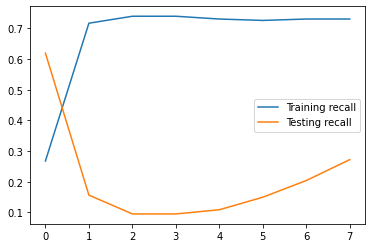

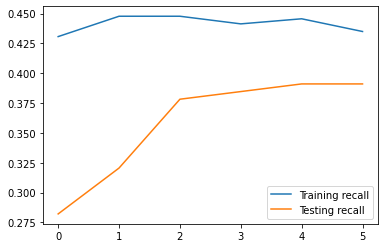

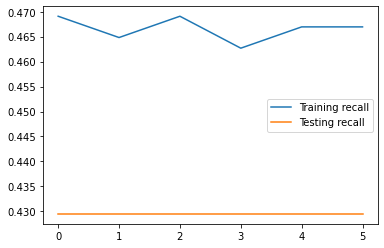

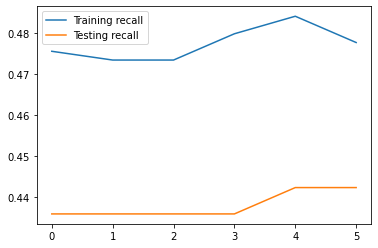

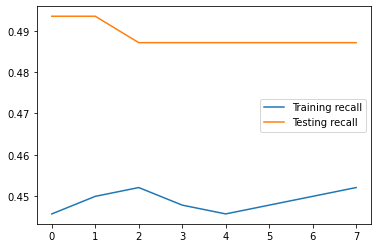

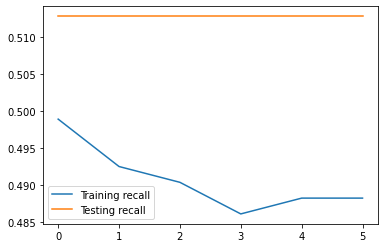

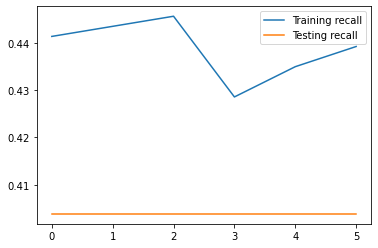

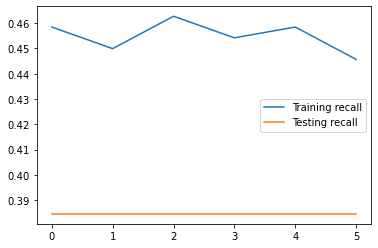

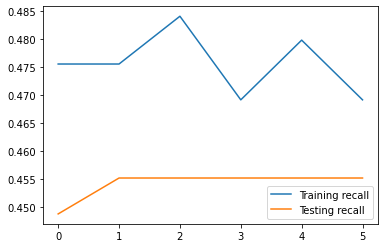

In [19]:
for i in range(len(histlist)):
    plt.figure()
    plt.plot(histlist[i]['recall'], label='Training recall')
    plt.plot(histlist[i]['val_recall'], label='Testing recall')
    plt.legend();

### Next Steps
* The next step in this project is to include the augmented data that we generated earlier.   

vX is the best scoring model so far, and likely represents the maximum recall achievable with this depth of neural network. External server options were pursued but still did not allow for fitting the entire dataset at once, let alone increasing CNN depth.

For optimum performance (outside the scope of this project for now), this neural net needs to be deeper. Given more memory and GPU access, first step would be to at least **double the number of filters** in each Conv2D layer. Secondly, most marine mammal acoustic CNNs utilize many _more_ Conv2D layers in addition to higher filter count.